In [125]:
%load_ext autoreload
%autoreload 2

from src.data import load_data
from src.functions import *
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


first, create deterministic/fourier features

In [126]:
df = load_data(to_period=True, granularity='monthly')

train_start="2002-01"
train_end="2010-12"
test_start = "2011-01"
test_end = "2018-08"

dp, X_dp, det_model, y_fit, y_resid, X_dp_train = make_deterministic_features(df, granularity='monthly', order=2, fourier_order=5, train_start=train_start, train_end=train_end)

In [127]:
y_train = df[train_start:train_end]
y_test = df[test_start:test_end]

X_dp_test = X_dp[test_start:test_end]
y_pred = pd.DataFrame(det_model.predict(X_dp_test), index=X_dp_test.index)

next, create residual features

In [128]:
y = load_data(to_period=True, granularity='monthly')

X_resid_full = make_residual_features(y, calendar_df=None, holidays=None, granularity='monthly', lags=[1, 2, 3, 6, 12], windows = [3, 6, 12])

In [129]:
# keep only rows with full lag/rolling features
X_resid = X_resid_full.dropna()

X_resid_train = X_resid[train_start:train_end]
X_resid_test = X_resid[test_start:test_end]


# align
idx = X_resid_train.index.intersection(y_resid.index)
X_resid_train = X_resid_train.loc[idx]
y_resid = y_resid.loc[idx]

In [130]:
print(X_resid_train.shape, y_resid.shape)
print(y_resid.isna().sum())

(96, 11) (96, 1)
PJME_MW    0
dtype: int64


In [131]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xr_train_scaled = scaler.fit_transform(X_resid_train)

In [132]:
xgb = XGBRegressor(random_state=42)
xgb.fit(Xr_train_scaled, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [133]:
# align indices
idx2 = y_pred.index.intersection(X_resid_test.index)

# deterministic baseline as a Series (grab first column)
y_deter_test = y_pred.iloc[:, 0].reindex(idx2)

# scale test features
Xr_test_scaled = scaler.transform(X_resid_test.loc[idx2, X_resid_train.columns])

# predict residuals
r_test = pd.Series(xgb.predict(Xr_test_scaled), index=idx2, name="resid_pred")

# hybrid forecast
y_hybrid_test = y_deter_test.add(r_test, fill_value=0)

In [134]:
y_hybrid_test

Datetime
2011-01    2.639581e+07
2011-02    2.368118e+07
2011-03    2.304760e+07
2011-04    2.037986e+07
2011-05    2.148718e+07
               ...     
2018-04    1.435620e+07
2018-05    1.611345e+07
2018-06    1.951197e+07
2018-07    2.174456e+07
2018-08    2.241814e+07
Freq: M, Length: 92, dtype: float64

### Next, Evaluation:

In [135]:
import numpy as np
import pandas as pd

# truth & the two model forecasts, aligned
y_true = y.loc[y_hybrid_test.index]
y_true = y_true.iloc[:, 0]
y_det = y_deter_test.loc[y_hybrid_test.index]
y_hybrid = y_hybrid_test

eval_df = pd.concat(
    [y_true.rename("y_true"), y_det.rename("y_det"), y_hybrid.rename("y_hybrid")],
    axis=1
).dropna()

# metrics
def mae(y, yhat):  return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat): return np.mean(np.abs((y - yhat) / y)) * 100

results = pd.DataFrame({
    "MAE":  [mae(y_true, y_det),    mae(y_true, y_hybrid)],
    "RMSE": [rmse(y_true, y_det),   rmse(y_true, y_hybrid)],
    "MAPE": [mape(y_true, y_det),   mape(y_true, y_hybrid)],
}, index=["Deterministic", "Hybrid"])

print(results.round(3))

                       MAE         RMSE   MAPE
Deterministic  1856284.542  3012595.643  18.94
Hybrid         1965701.999  3127216.026  19.12


In [136]:
# baselines, aligned to test window
naive_1m = y_true.shift(1).reindex(eval_df.index)
naive_7m = y_true.shift(7).reindex(eval_df.index)

eval_2 = pd.concat(
    [eval_df[["y_true", "y_det", "y_hybrid"]],
    naive_1d.rename("naive_1m"),
    naive_7d.rename("naive_7m")],
    axis=1).dropna()


# metrics
naive = pd.DataFrame({
    "MAE": [mae(eval_2["y_true"], eval_2["naive_1m"]),
            mae(eval_2["y_true"], eval_2["naive_7m"])],
    "RMSE": [rmse(eval_2["y_true"], eval_2["naive_1m"]),
             rmse(eval_2["y_true"], eval_2["naive_7m"])],
    "MAPE": [mape(eval_2["y_true"], eval_2["naive_1m"]),
             mape(eval_2["y_true"], eval_2["naive_7m"])],
}, index=["Naive-1M", "Naive-7M"])

# combine with earlier results
results_all = pd.concat([results, naive]).round(3)
print(results_all)

                       MAE         RMSE    MAPE
Deterministic  1856284.542  3012595.643  18.940
Hybrid         1965701.999  3127216.026  19.120
Naive-1M       2706521.129  3918011.410  25.965
Naive-7M       2841168.576  4176670.250  26.106


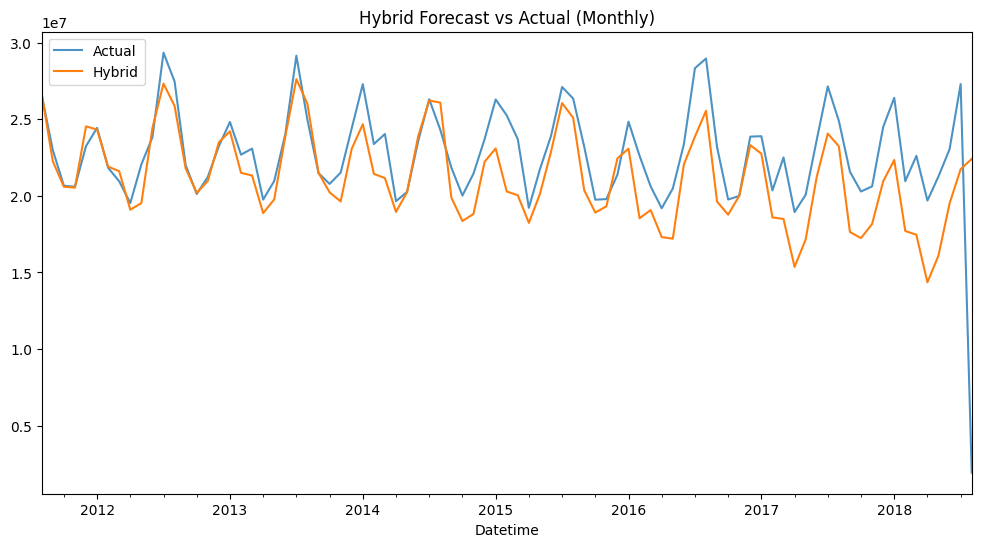

In [137]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["y_hybrid"].iloc[-200:].plot(ax=ax, label="Hybrid")

ax.set_title("Hybrid Forecast vs Actual (Monthly)")
ax.legend()
plt.savefig("../reports/figures/Hybrid-forecast-monthly.png")

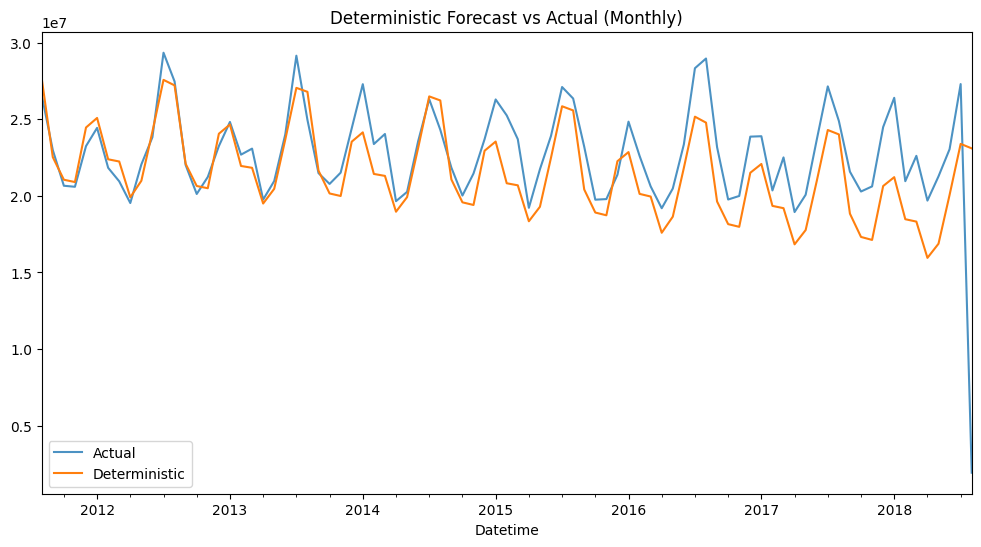

In [138]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["y_det"].iloc[-200:].plot(ax=ax, label="Deterministic")

ax.set_title("Deterministic Forecast vs Actual (Monthly)")
ax.legend()
plt.savefig("../reports/figures/Deterministic-forecast-monthly.png")

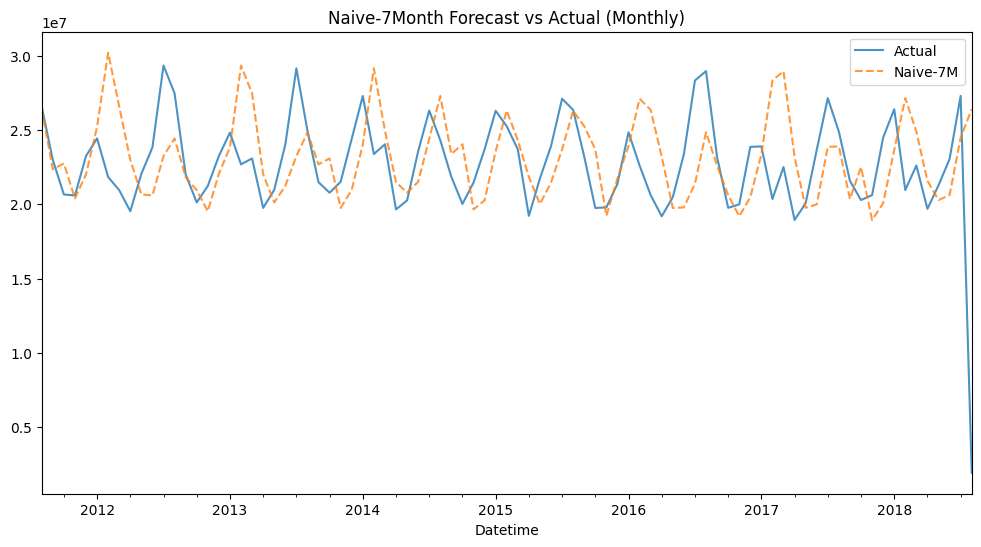

In [139]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["naive_7m"].iloc[-200:].plot(ax=ax, label="Naive-7M", linestyle="--", alpha=0.8)

ax.set_title("Naive-7Month Forecast vs Actual (Monthly)")
ax.legend()
plt.savefig("../reports/figures/naive7m-forecast-month.png")